[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_09_redes_neuronales-published.ipynb)

# Redes neuronales


Vamos nuevamente a trabajar con los datos de `iris` para entrenar (y antes construir) una Red Neuronal.

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    dataset = load_iris()
    X = dataset["data"]
    y = dataset["target"]
    y = LabelEncoder().fit_transform(y)
    return np.array(X), np.array(y)
X, y = get_data()
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

La propuesta es empezar por el esqueleto de las 2 clases que usaremos para esta tarea e ir implementado los métodos a medida que avancemos.

Al final de este notebook se encuentran ambas clases completas. Pueden copiar el código desde allí mismo o implementarlo. La idea es que en cada avance podamos comprender la parte del proceso que estamos realizando, por lo cual se recomienda seguir la guia propuesta e ir completando sólo lo que es necesario para cada punto.

In [2]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z_curr = np.dot(inputs, weights.T) + bias

        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)

        return A_curr, Z_curr

    def relu(self, inputs):
        """
        ReLU: función de activación
        """

        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
         
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ

In [3]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = [] ## capas
        self.arquitectura = [] ## mapeo de entradas -> salidas
        self.pesos = [] ## W, b
        self.memoria = [] ## Z, A
        self.gradientes = [] ## dW, db
        self.lr = learning_rate
        
    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa)
            
    def _compile(self, data):
        """
        Inicializar la arquitectura
        """
        for idx, _ in enumerate(self.red):
            if idx == 0:
                self.arquitectura.append({'input_dim': data.shape[1], 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            elif idx > 0 and idx < len(self.red)-1:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            else:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'softmax'})
        return self

    def _init_weights(self, data):
        """
        Inicializar arquitectura y los pesos
        """
        self._compile(data)

        np.random.seed(99)

        for i in range(len(self.arquitectura)):
            self.pesos.append({
                'W':np.random.uniform(low=-1, high=1, 
                        size=(self.arquitectura[i]['input_dim'],
                            self.arquitectura[i]['output_dim']
                            )),
                'b':np.zeros((1, self.arquitectura[i]['output_dim']))})

        return self
    
    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A_curr = data

        for i in range(len(self.pesos)):
            A_prev = A_curr
            A_curr, Z_curr = self.red[i].forward(inputs=A_prev, 
                                                    weights=self.pesos[i]['W'].T, 
                                                    bias=self.pesos[i]['b'], 
                                                    activation=self.arquitectura[i]['activation'])

            self.memoria.append({'inputs':A_prev, 'Z':Z_curr})

        return A_curr
    
    def _backprop(self, predicted, actual):
        """
        Pasada backward completa por la red
        """
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples

        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev

            A_prev = self.memoria[idx]['inputs']
            Z_curr = self.memoria[idx]['Z']
            W_curr = self.pesos[idx]['W']

            activation = self.arquitectura[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr.T, Z_curr, A_prev, activation)

            self.gradientes.append({'dW':dW_curr, 'db':db_curr})

        self.gradientes = list(reversed(self.gradientes))  # Reverse the gradients list

    def _update(self):
        """
        Actualizar el modelo --> lr * gradiente
        """
        lr = self.lr
        for idx, layer in enumerate(self.red):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy después de cada iteración
        """
        return np.mean(np.argmax(predicted, axis=1)==actual)
        
    def _calculate_loss(self, predicted, actual):
        """
        Calculate cross-entropy loss after each iteration
        """
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss

    def train(self, X_train, y_train, epochs):
        """
        Entrenar el modelo Stochastic Gradient Descent
        """
        self.loss = []
        self.accuracy = []

        self._init_weights(X_train)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

            self._backprop(predicted=yhat, actual=y_train)

            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)

Los items que se presentan a continuación tienen como objetivo explorar las clases que componen la red neuronal propuesta, comprender su arquitectura y funcionamiento.

Nuevamente, lo ideal es no mirar todos los métodos hasta que llegue el momento de utilizarlos. 

1. Crear una Red Neuronal con 6 nodos en la primera capa, 8 en la segunda, 10 en la tercer y finalmente 3 en la última, utilizando los métodos `add()`, `_compile()` de la clase `RedNeuronal` y el constructor de la clase `Capa`.
  
    Imprimir la arquitectura del modelo y asegurarse de obtener:

    ```
    [{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'},
    {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'},
    {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'},
    {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]
    ```

    Dibujar la red en papel.

In [4]:
red = RedNeuronal()
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))
red._init_weights(X)
print(red.arquitectura)

[{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'}, {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'}, {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}, {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]


2. Inicializar los pesos de la red del punto anterior (`_init_weights(datos)`) y verificar que los pesos tienen dimensión correcta:

    ```
    capa 0: w=(4, 6) - b=(1, 6)
    capa 1: w=(6, 8) - b=(1, 8)
    capa 2: w=(8, 10) - b=(1, 10)
    capa 3: w=(10, 3) - b=(1, 3)
    ```

    Definir las matrices que se corresponden con las capas de manera que una pasada pueda ser interpretada como el producto de todas ellas. Recordar que en cada paso por cada capa estaremos computando por cada neurona de la capa siguiente:

    $$Z = \sum_{i=1}^{n} X_i \times W_i + b$$

In [5]:
print(red.pesos[0]['W'].shape, red.pesos[0]['b'].shape)
print(red.pesos[1]['W'].shape, red.pesos[1]['b'].shape)
print(red.pesos[2]['W'].shape, red.pesos[2]['b'].shape)
print(red.pesos[3]['W'].shape, red.pesos[3]['b'].shape)

(4, 6) (1, 6)
(6, 8) (1, 8)
(8, 10) (1, 10)
(10, 3) (1, 3)


3. Funciones de activación de una `Capa`:

    1. Verificar que el funcionamiento de `ReLU` se corresponda con:

        ```
        if input > 0:
            return input
        else:
            return 0
        ``` 

    1. Verificar que el funcionamiento de `softmax` se corresponda con:

        $$\sigma(Z)_i = \frac{e^{z_i}}{\sum_{i=1}^{n} e^{z_j}}$$

    **Nota**: para probar estos dos métodos puede ser util construir un vector de la siguiente manera: `np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])` que genera un vector de tamaño (1,5).

4. Avancemos con `_forwardprop(datos)`, si corremos la red inicializada con los datos:

    1. ¿Qué nos tipo de objeto nos devuelve este método?

    1. ¿Qué quiere decir cada uno de los valores?

    1. La primera fila, que se correspondería con la primera observación del dataset, ¿qué resultados nos da?¿qué es más probable: 'setosa', 'versicolor' o 'virginica'?¿qué valor es el real?¿por qué?

In [6]:
model = RedNeuronal()
model.add(Capa(6))
model.add(Capa(8))
model.add(Capa(10))
model.add(Capa(3))
model._init_weights(X)

out = model._forwardprop(X)
print('SHAPE:', out.shape)
print('Probabilties at idx 0:', out[0])
print('SUM:', sum(out[0]))

SHAPE: (150, 3)
Probabilties at idx 0: [0.16617107 0.81859653 0.0152324 ]
SUM: 1.0


5. Arrancamos a propagar para atrás lo aprendido en la primera pasada. Esto lo realizaremos con el método `_backprop`.

    1. ¿Cómo es la derivada de la función de activación `ReLU`?¿Su código es correcto?

    1. ¿Cuál es la operación matemática que hace la función `backward` de la clase `Capa` en el caso de tener como activación a `relu`?

    1. El método `_backprop` toma 2 parámetros: `predicted` y `actual`. ¿qué debemos pasarle en dicho lugar?

        Si la respuesta no fue: en `predicted` le pasamos el resultado de `_forwardprop(...)` y en `actual` le pasamos `y`.... volver a pensarlo. ;-)

    1. Verificar que los `gradientes` y los `pesos` para cada una de las capas tienen el mismo tamaño.

In [7]:
model._backprop(predicted=out, actual=y)
print(model.gradientes[0]['dW'].shape, model.pesos[3]['W'].shape)
print(model.gradientes[1]['dW'].shape, model.pesos[2]['W'].shape)
print(model.gradientes[2]['dW'].shape, model.pesos[1]['W'].shape)
print(model.gradientes[3]['dW'].shape, model.pesos[0]['W'].shape)

(4, 6) (10, 3)
(6, 8) (8, 10)
(8, 10) (6, 8)
(10, 3) (4, 6)


6. Preparemos por último las funciones necesarias para el entrenamiento. Describir brevemente qué hacen las funciones:

    - `_get_accuracy`
    - `_calculate_loss`
    - `_update`

7. Incluyamos finalmente la función `train` y entrenemos una red con la arquitectura propuesta en el punto 1 por 200 epocas.

    1. ¿Qué valores se imprimen?¿Qué es posible interpretar de ellos?

    1. Graficar el _accuracy_ y la _loss_ que arroja el entramiento en función de las _epochs_. ¿Qué se puede concluir? Probablemente la señal sea ruidosa, por lo que se recomienda hacer un suavizado por ventanas deslizantes.

In [8]:
model = RedNeuronal()
model.add(Capa(6))
model.add(Capa(8))
model.add(Capa(10))
model.add(Capa(3))

model.train(X, y, 500)

EPOCH: 0, ACCURACY: 0.25333333333333335, LOSS: 2.537401260962661
EPOCH: 20, ACCURACY: 0.3333333333333333, LOSS: 2.56037553510407
EPOCH: 40, ACCURACY: 0.6266666666666667, LOSS: 2.005409652699847
EPOCH: 60, ACCURACY: 0.66, LOSS: 1.683803621672438
EPOCH: 80, ACCURACY: 0.6333333333333333, LOSS: 1.5293444244585745
EPOCH: 100, ACCURACY: 0.48, LOSS: 1.3522398101899922
EPOCH: 120, ACCURACY: 0.48, LOSS: 1.1284742049684533
EPOCH: 140, ACCURACY: 0.54, LOSS: 0.9497974088127585
EPOCH: 160, ACCURACY: 0.6333333333333333, LOSS: 0.8507306584602737
EPOCH: 180, ACCURACY: 0.7266666666666667, LOSS: 0.7717923934635368
EPOCH: 200, ACCURACY: 0.7866666666666666, LOSS: 0.7294208757189596
EPOCH: 220, ACCURACY: 0.7466666666666667, LOSS: 0.7188370682140136
EPOCH: 240, ACCURACY: 0.72, LOSS: 0.7204847320119498
EPOCH: 260, ACCURACY: 0.74, LOSS: 0.721856357274429
EPOCH: 280, ACCURACY: 0.8133333333333334, LOSS: 0.6930117989336924
EPOCH: 300, ACCURACY: 0.8466666666666667, LOSS: 0.6447537788782514
EPOCH: 320, ACCURACY: 0

([np.float64(0.25333333333333335),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.013333333333333334),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.31333333333333335),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.36),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.52),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.3333333333333333),
  np.float64(0.34),
  np.float64(0.3333333333333333),
  np.float64(0.586

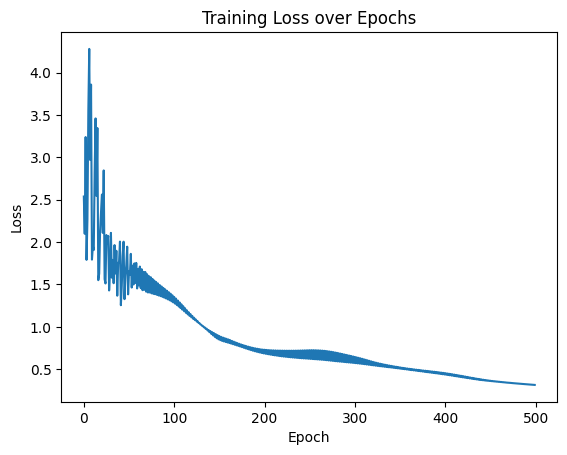

In [9]:
plt.plot(model.loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

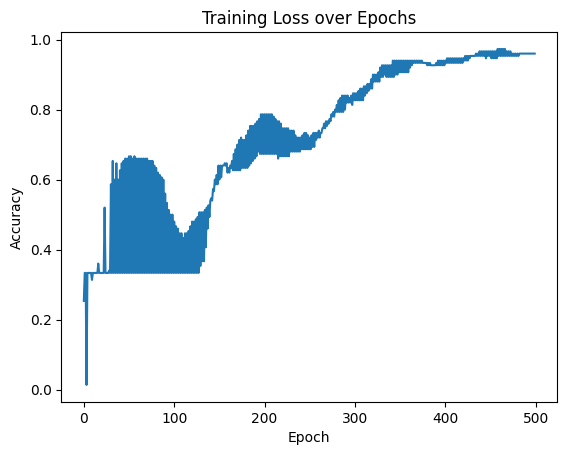

In [10]:
plt.plot(model.accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss over Epochs')
plt.show()

8. Reimplementar la clase `RedNeuronal` utilizando PyTorch

    Hasta ahora hemos construido nuestra propia red neuronal "desde cero", lo cual nos permitió comprender en profundidad cómo funciona cada componente: inicialización de pesos, funciones de activación, forward y backward propagation, cálculo de loss y accuracy, y actualización de pesos.

    Sin embargo, en proyectos reales y más complejos, utilizamos frameworks como **PyTorch** que abstraen estas tareas, permitiéndonos enfocarnos más en el diseño de la arquitectura y el análisis de los resultados.  

    **Objetivo de este inciso**: recrear la arquitectura y entrenamiento de nuestra red neuronal, pero usando herramientas provistas por PyTorch. Esto implica:

    1. Implementar una clase `RedNeuronalTorch` que herede de `nn.Module` y contenga una red con la misma arquitectura:  
    - Entrada de dimensión 4 (por las características del dataset Iris)
    - Capas ocultas de 6, 8 y 10 nodos respectivamente
    - Capa de salida con 3 nodos y activación `softmax`

    2. Entrenar esta nueva red por 200 épocas utilizando:
    - Función de pérdida: `nn.CrossEntropyLoss`
    - Optimizador: `torch.optim.SGD`
    - Tasa de aprendizaje: 0.01

    3. Comparar los resultados obtenidos con los del entrenamiento anterior (implementación manual). Algunas preguntas a responder:
    - ¿La convergencia es más rápida o más lenta?
    - ¿Cómo se comporta la pérdida durante el entrenamiento?
    - ¿Cuál implementación fue más fácil de modificar o extender?

    4. Graficar la evolución de la **pérdida** y el **accuracy** durante las épocas para ambas implementaciones (manual y PyTorch), idealmente en la misma figura para facilitar la comparación. Podés aplicar una media móvil para suavizar la señal.

    > 💡 **Sugerencia pedagógica**: antes de realizar este inciso, se recomienda repasar los notebooks `9a` y `9b`, donde se presentan una introducción a los tensores y al workflow de ML usando PyTorch.


Crédito: este ejercicio se base en la propuesta de Joe Sasson publicada en [Towards Data Science](https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605).

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
class RedNeuronalTorch(nn.Module):
    def __init__(self):
        super(RedNeuronalTorch, self).__init__()
        self.capa_1 = nn.Linear(4, 6)
        self.capa_2 = nn.Linear(6, 8)
        self.capa_3 = nn.Linear(8, 10)
        self.capa_4 = nn.Linear(10, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        A = self.relu(self.capa_1(x))
        A = self.relu(self.capa_2(A))
        A = self.relu(self.capa_3(A))
        A = self.capa_4(A)
        return A
    
    def train_aux(self, X_train, y_train, epochs=200):
        # Convert numpy arrays to torch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long) # integer

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=0.01)

        self.loss = []
        self.accuracy = []

        torch.manual_seed(1)

        for i in range(epochs):

            optimizer.zero_grad()

            out = self.forward(X_train)

            loss = criterion(out, y_train)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(out, 1)
            acc = (predicted == y_train).float().mean().item()

            self.loss.append(loss.item())
            self.accuracy.append(acc)

            if i % 20 == 0:
                print(f'EPOCH: {i}, ACCURACY: {acc}, LOSS: {loss.item()}')

        return (self.accuracy, self.loss)
        

In [13]:
model_tch = RedNeuronalTorch()

model_tch.train_aux(X, y, epochs=500)

EPOCH: 0, ACCURACY: 0.3333333432674408, LOSS: 1.1006604433059692
EPOCH: 20, ACCURACY: 0.3333333432674408, LOSS: 1.092431902885437
EPOCH: 40, ACCURACY: 0.3333333432674408, LOSS: 1.0863776206970215
EPOCH: 60, ACCURACY: 0.4466666579246521, LOSS: 1.0812947750091553
EPOCH: 80, ACCURACY: 0.5199999809265137, LOSS: 1.073717713356018
EPOCH: 100, ACCURACY: 0.4000000059604645, LOSS: 1.0676708221435547
EPOCH: 120, ACCURACY: 0.35333332419395447, LOSS: 1.0611644983291626
EPOCH: 140, ACCURACY: 0.35333332419395447, LOSS: 1.054257869720459
EPOCH: 160, ACCURACY: 0.3866666555404663, LOSS: 1.046343207359314
EPOCH: 180, ACCURACY: 0.5799999833106995, LOSS: 1.0369346141815186
EPOCH: 200, ACCURACY: 0.6666666865348816, LOSS: 1.0255100727081299
EPOCH: 220, ACCURACY: 0.6666666865348816, LOSS: 1.0114833116531372
EPOCH: 240, ACCURACY: 0.6666666865348816, LOSS: 0.9940788745880127
EPOCH: 260, ACCURACY: 0.6733333468437195, LOSS: 0.9723523855209351
EPOCH: 280, ACCURACY: 0.6733333468437195, LOSS: 0.9451557397842407
EPO

([0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3400000035762787,
  0.3400000035762787,
  0.340000

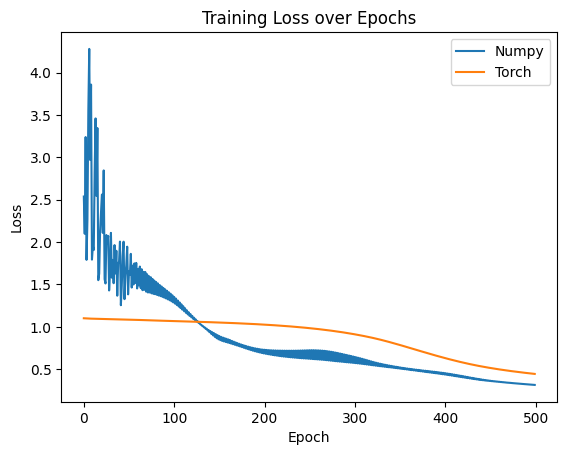

In [17]:
plt.plot(model.loss, label='Numpy')
plt.plot(model_tch.loss, label='Torch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

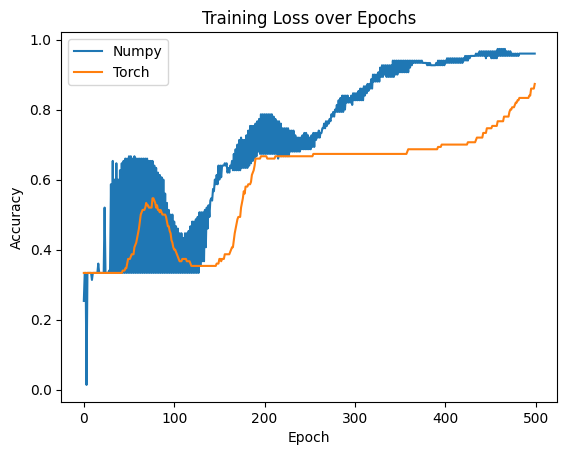

In [15]:
plt.plot(model.accuracy, label='Numpy')
plt.plot(model_tch.accuracy, label='Torch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()